In [1]:
import pandas as pd 
import numpy as np 
import os
import seaborn as sns
import matplotlib.pyplot as plt
from src.files.fasta import FASTAFile
from Bio import Phylo, Align
from itertools import product, combinations
from utils import *
from src.coevolution import get_scores
from scipy.stats import mannwhitneyu
from src.files.itol import *
import io
import re
from src.tree import * 
from src.stop_codon import *  
from src.data import get_arf1_data

%load_ext autoreload 
%autoreload 2

levels = ['phylum', 'class', 'order', 'family', 'genus', 'species']

MAX_E_VALUE = 1e-170

In [2]:
def get_tag_percent_categories(arf1_df:pd.DataFrame):
    conditions = [arf1_df.tag_percent < 0.05, (arf1_df.tag_percent >= 0.05) & (arf1_df.tag_percent < 0.15), arf1_df.tag_percent >= 0.15]
    categories = ['low UAG', 'med. UAG', 'high UAG']
    arf1_df['category'] = np.select(conditions, categories, default='none')
    return arf1_df

In [3]:
if not os.path.exists('../data/arf1_methanosarcinaceae.csv'):
    # I think it might be a good idea to somewhat augment the dataset, as the sample size just seems to small. 
    metadata_df = gtdb_load_ar53_metadata()
    metadata_df = metadata_df[metadata_df.family == 'Methanosarcinaceae'].copy()
    metadata_df = metadata_df[metadata_df.gtdb_representative == 't'].copy()
    genome_ids = metadata_df.index.values
    print('Num. GTDB genome representatives in Methanosarcinaceae:', len(metadata_df))

    downloaded_genome_ids = [path.replace('.fn', '') for path in os.listdir('../data/ncbi/genomes/')]
    genome_ids = np.intersect1d(genome_ids, downloaded_genome_ids)
    print('Num. GTDB representatives in Methanosarcinaeae which are already downloaded:', len(np.intersect1d(downloaded_genome_ids, metadata_df.index.values)))

    hmmer_df = hmmer_load(genome_ids=genome_ids)
    hmmer_df = hmmer_df[(hmmer_df.query_name == 'aRF1_eRF1') & (hmmer_df.genome_id.isin(metadata_df.index.values))].copy()
    hmmer_df = hmmer_df.sort_values('e_value').drop_duplicates('genome_id')

    # build_stop_codon_metadata_dataset(genome_ids, path='../data/methanosarcinaceae_stop_codon_metadata.csv')
    taxon_arf1_df = get_arf1_data(hmmer_df=hmmer_df, genome_ids=genome_ids)

    stop_codon_metadata_df = pd.read_csv('../data/arf1_methanosarcinaceae_stop_codon_metadata.csv', index_col=0)
    for col in stop_codon_metadata_df.columns:
        taxon_arf1_df[col] = taxon_arf1_df.genome_id.map(stop_codon_metadata_df[col])
    taxon_arf1_df['tag_percent'] = taxon_arf1_df.TAG / taxon_arf1_df['total'] # Calculate the fraction of TAG stop codons. 

    for level in levels:
        taxon_arf1_df[level] = taxon_arf1_df.genome_id.map(metadata_df[level])
        
    taxon_arf1_df['length'] = taxon_arf1_df.seq.apply(len)
    taxon_arf1_df = taxon_arf1_df[taxon_arf1_df.length > 350].copy()
    taxon_arf1_df.to_csv('../data/arf1_methanosarcinaceae.csv')

taxon_arf1_df = pd.read_csv('../data/arf1_methanosarcinaceae.csv', index_col=0)
taxon_arf1_df = taxon_arf1_df[taxon_arf1_df.e_value < MAX_E_VALUE].copy()

In [4]:
len(taxon_arf1_df)

127

In [5]:
msa_path = '../data/arf1_cleaned.afa'
new_msa_path = '../data/arf1_cleaned_with_methanosarcinaceae.afa'
fa_path = '../data/arf1_methanosarcinaceae.fa' # The new sequences to add to the MSA. 

if not os.path.exists(new_msa_path):
    ids_in_msa = FASTAFile().from_fasta(msa_path).ids
    FASTAFile().from_df(taxon_arf1_df[~taxon_arf1_df.index.isin(ids_in_msa)].drop(columns=['description'])).write(fa_path)
    
    # cmd = f'muscle --profile -in1 {msa_path} -in2 {run_muscle(fa_path)} -out {new_msa_path}' # Not sure why this one isn't working... 
    # cmd = f'~/muscle5.1.linux_intel64 -super5 {msa_path} {run_muscle(fa_path)} --output {new_msa_path}'
    cmd = f'mafft --add {msa_path} {run_muscle(fa_path)} > {new_msa_path}'
    subprocess.run(cmd, shell=True, check=True)

In [6]:
arf1_df = load_arf1_dataset(exclude_genome_ids=[])
arf1_df = pd.concat([arf1_df, taxon_arf1_df])
arf1_df = arf1_df[~arf1_df.index.duplicated()].copy()
arf1_df = get_tag_percent_categories(arf1_df)

msa_df = load_msa(new_msa_path, ids=arf1_df.index, conservation_threshold=0.8)
msa_df[levels] = arf1_df[levels]

seq = ''.join(msa_df.iloc[0])
domain_boundaries = get_domain_boundaries(seq)

# print('Num. sequences being discarded which are not in either Pyl+ recoded or Pyl- categories:', (arf1_df.category == 'low UAG').sum())
# arf1_df = arf1_df[arf1_df.category != 'low UAG'].copy()
# print('Num. potentially-mislabeled Pyl- sequences being discarded:', ((arf1_df.category == 'high UAG') & (arf1_df.tag_percent < 0.05)).sum())
# arf1_df = arf1_df[~((arf1_df.category == 'high UAG') & (arf1_df.tag_percent < 0.05))].copy()

# min_phylum_size = 10
# phylum_counts = arf1_df.phylum.value_counts()
# mask = arf1_df.phylum.isin(phylum_counts[phylum_counts >= min_phylum_size].index.values)
# print(f'Discarding {(~mask).sum()} sequences from phyla which do not meet the minimum size threshold.')
# arf1_df = arf1_df[arf1_df.phylum.isin(phylum_counts[phylum_counts >= min_phylum_size].index.values)].copy()

# arf1_df['category'] = arf1_df.category.replace({'low UAG recoded':'low UAG'})


get_domain_boundaries: NIKS boundaries 52-56.
get_domain_boundaries: YxCxxxF boundaries 116-123.
get_domain_boundaries: GTS boundaries 20-23.
get_domain_boundaries: GGQ boundaries 174-177.


In [7]:
# for level in levels:
#     print(f'Num {level}:', arf1_df[level].nunique())

# # Confirm that all genuses are homogenous, either all low UAG or high UAG. 
# for genus, df in arf1_df.groupby('genus'):
#     assert df.category.nunique() == 1, f'The genus {genus} contains both low UAG and high UAG organisms.'

# # Look at the distribution of genus sizes. 
# fig, axes = plt.subplots(ncols=len(levels) - 1, figsize=(3 * (len(levels) - 1), 3))
# for i in range(len(levels) - 1):
#     figure_df = pd.DataFrame(arf1_df.drop_duplicates(levels[i + 1])[levels[i]].value_counts())
#     sns.histplot(figure_df, x='count', color='lightgray', ax=axes[i], discrete=True)
#     axes[i].set_title(f'{levels[i + 1]} per {levels[i]}')
#     axes[i].set_xlim(xmin=0, xmax=figure_df['count'].max())
#     axes[i].set_ylabel('density')

# fig.tight_layout()
# plt.show()

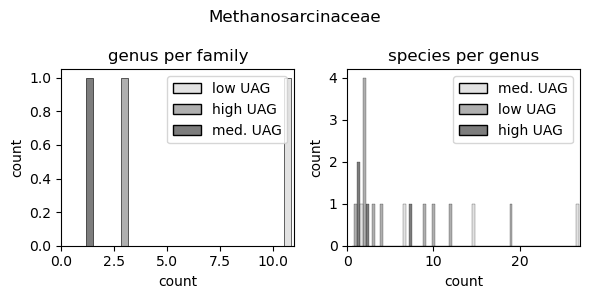

In [82]:
# Look at the distribution of genus sizes. 

def figure(arf1_df:pd.DataFrame, level:str='family', taxon='Methanosarcinaceae'):
    levels = ['family', 'genus', 'species']
    # palette = {'low UAG':'steelblue', 'high UAG':'lightblue'}

    arf1_df = arf1_df[arf1_df[level] == taxon].copy()
    fig, axes = plt.subplots(ncols=len(levels) - 1, figsize=(3 * (len(levels) - 1), 3))
    
    for i in range(len(levels) - 1):
        figure_df = pd.DataFrame(arf1_df.drop_duplicates(levels[i + 1]).value_counts([levels[i], 'category']))
        sns.histplot(figure_df, x='count', color='gray', ax=axes[i], hue='category', discrete=True, palette='Grays', common_norm=False, multiple='dodge', stat='count')
        axes[i].set_title(f'{levels[i + 1]} per {levels[i]}')
        axes[i].set_xlim(xmin=0, xmax=figure_df['count'].max())
        axes[i].set_ylabel('count')
        axes[i].get_legend().set_title('')

    fig.suptitle(taxon)
    fig.tight_layout()
    plt.show()

figure(arf1_df)

In [9]:
level, taxon = 'family', 'Methanosarcinaceae'
# level, taxon = 'family', 'Methanomethylophilaceae'
# level, taxon = 'order', 'Methanosarcinales'
# level, taxon = 'order', 'Methanomassiliicoccales'
taxon_ids = arf1_df[arf1_df[level] == taxon].index.tolist()

for category, df in arf1_df.groupby('category'):
    print(f'Num. {category} in {taxon}:', (df[level] == taxon).sum())

Num. high UAG in Methanosarcinaceae: 11
Num. low UAG in Methanosarcinaceae: 66
Num. med. UAG in Methanosarcinaceae: 51


In [10]:
def _get_aas(use_dayhoff:bool=True):
    if not use_dayhoff:
        aas = 'ACDEFGHIKLMNPQRSTVWY-X' 
        aa_idx = {a:i for i, a in enumerate(aas)}
    else:
        aas = ''.join(np.unique(list(dayhoff.values()))) + '-X'
        aa_idx = {a:i for i, a in enumerate(aas)}
    return aas, aa_idx

def _get_frequency_matrix(msa_df:pd.DataFrame, use_dayhoff:bool=True):
    '''Frequency matrix is a matrix of shape (num_positions, alphabet_size).'''
    aas, aa_idx = _get_aas(use_dayhoff=use_dayhoff)
    alignment = msa_df[[c for c in msa_df.columns if isinstance(c, int)]].values
    m = np.zeros((alignment.shape[1], len(aas)), dtype=float)
    for aa in aas:
        m[:, aa_idx[aa]] = np.sum(alignment == aa, axis=0)
    m = m / m.sum(axis=1, keepdims=True)
    return m

def get_frequency_matrix(msa_df:pd.DataFrame, normalize:bool=True, use_dayhoff:bool=True):
    aas, aa_idx = _get_aas(use_dayhoff=use_dayhoff)
    msa_df = msa_df.copy().replace(dayhoff) if use_dayhoff else msa_df 
    # levels = ['phylum', 'class', 'order', 'family', 'genus', 'species']
    levels = ['family', 'genus', 'species']
    levels = [(levels[i], levels[i + 1]) for i in range(len(levels) - 1)][::-1]
    
    if not normalize:
        M = _get_frequency_matrix(msa_df, use_dayhoff=use_dayhoff)
    else:
        # Normalized by collapsing the tree to the phylum level. I think a better approach might be collapsing to the family level. 
        M = {species:_get_frequency_matrix(df, use_dayhoff=use_dayhoff) for species, df in msa_df.groupby('species')}
        for upper_level, lower_level in levels:
            M_ = dict()
            for upper_taxon, df in msa_df.groupby(upper_level):
                m = np.mean([M[lower_taxon] for lower_taxon in df[lower_level].unique()], axis=0)
                M_[upper_taxon] = m
            M = M_
        M = np.mean(list(M.values()), axis=0)
                    
    M_df = pd.DataFrame(M, columns=list(aas))
    M_df['position'] = M_df.index
    return M_df


In [11]:

# What does it mean for a position to be significant at the order level and not the family level, and vice versa?

# If a position is significant at the family level, but not the order level, this implies that very few high UAG genomes in the family have the
# residue at that position, but many of the high UAG members of the order do. If there isn't much diversity within the family, this could just
# be a random mutation, and there is no real evidence of conservation. Conversely, if it is not significant at the family level, this
# could mean that sequences in the same family have developed a compensatory mutation that is uncommon within the order 
# that means there is no functional effect. 

# If it is significant at the order level, but not the family level, this implies that very few high UAG organisms in the order overall
# have the residue at that position, but those in the family do. At least in Methanosarcinales, all low UAG are contained within the same
# family, which means that this is basically pointing out which residues are the most different between the family and the rest of the order.

In [12]:
def get_divergence_scores(M):

    scores = np.linalg.norm(M[0].drop(columns=['position']).values - M[1].drop(columns=['position']).values, ord=1, axis=1)
    scores = scores / 2
    score_df = dict()
    score_df['score'] = scores
    score_df['position'] = np.arange(len(scores))
    return pd.DataFrame(score_df)

In [14]:
# fig, ax = plt.subplots(figsize=(4, 4))
# sns.ecdfplot(taxon_arf1_df, x='e_value', color='gray')
# ax.set_xscale('log')
# ax.set_ylabel('proportion')
# plt.show()

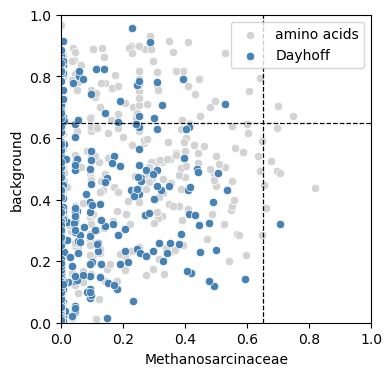

In [15]:
masks = dict()
masks[taxon] = (arf1_df.category == 'low UAG') & (arf1_df[level] == taxon)
masks[f'{taxon}_background'] = (arf1_df.category == 'high UAG') & (arf1_df[level] == taxon)
masks['background'] = (arf1_df.category == 'high UAG')

figure_dfs = dict()

fig, ax = plt.subplots(figsize=(4, 4))
for use_dayhoff in [False, True]:
    M = {group:get_frequency_matrix(msa_df[mask].copy(), use_dayhoff=use_dayhoff, normalize=True) for group, mask in masks.items()}
    figure_df = get_divergence_scores((M[taxon], M[f'{taxon}_background'])).assign(category=taxon)
    # NOTE: Found that normalizing doesn't really affect that much. 
    figure_df = pd.concat([figure_df, get_divergence_scores((M[taxon], M['background'])).assign(category='background')], axis=0)
    figure_df = figure_df.pivot(columns='category', values='score', index='position').reset_index()
    figure_dfs[use_dayhoff] = figure_df.copy()

    label = 'Dayhoff' if use_dayhoff else 'amino acids'
    color = 'steelblue' if use_dayhoff else 'lightgray'
    sns.scatterplot(figure_df, x=f'{taxon}', y='background', ax=ax, color=color, label=label)

ax.legend()
ax.set_xlim(xmin=0, xmax=1)
ax.set_ylim(ymin=0, ymax=1)

threshold = 0.65
ax.axvline(threshold, ls='--', lw=0.9, color='black')
ax.axhline(threshold, ls='--', lw=0.9, color='black')
plt.show()

In [16]:
figure_df = figure_dfs[False]

mask = (figure_df[taxon] > threshold)
# mask = (figure_df['background'] > threshold)
positions = figure_df[mask].position

scores = dict()
scores[True] = figure_dfs[True][mask][taxon] # Also get the divergence scores. 
scores[False] = figure_dfs[False][mask][taxon] # Also get the divergence scores. 

print(f'Interesting positions for {taxon}:', ', '.join(positions.astype(str)))

Interesting positions for Methanosarcinaceae: 4, 105, 132, 162, 244, 277, 280, 306, 323


In [17]:
pd.crosstab(msa_df[msa_df[level] == taxon][67], arf1_df[arf1_df[level] == taxon]['category'])

category,high UAG,low UAG,med. UAG
67,,,
D,0,34,6
E,11,32,44
S,0,0,1


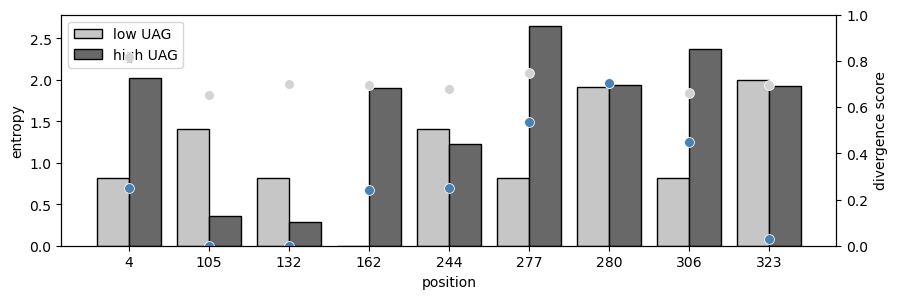

In [18]:

# How conserved are these potentially-relevant mutation sites?
# Worth seeing if they are high entropy, as high mutation rates in these positions might just indicate that 
# these positions are tolerant to mutation.
 
# It is not clear if high entropy in low UAG necessarily means the mutation is unimportant, as it could be that simply avoiding the "correct" residue which 
# allows for omnipotence is sufficient for the desired effect. Probably the residues should be conserved within at least one of the two groups, though. 

# print('Num. high UAG species:', ((arf1_df.category == 'high UAG') & (arf1_df[level] == taxon)).sum())
# print('Num. low UAG species:', ((arf1_df.category == 'low UAG') & (arf1_df[level] == taxon)).sum())

def get_entropy(M, position:int=None):
    frequencies = M[M.position == position].drop(columns=['position']).copy()
    frequencies = frequencies.values.ravel()
    frequencies = frequencies[frequencies > 0].copy()
    entropy = (-frequencies * np.log2(frequencies)).sum()
    return entropy

def figure(msa_df:pd.DataFrame=msa_df, positions=None, scores=None, level:str=level, taxon:str=taxon, use_dayhoff=False):
    msa_df = msa_df.loc[arf1_df.index].copy()

    M = dict()
    M['low UAG'] = get_frequency_matrix(msa_df[(arf1_df.category == 'high UAG') & (arf1_df[level] == taxon)], use_dayhoff=use_dayhoff, normalize=True)
    M['high UAG'] = get_frequency_matrix(msa_df[(arf1_df.category == 'low UAG') & (arf1_df[level] == taxon)], use_dayhoff=use_dayhoff, normalize=True)
    
    figure_df = list()
    for position in positions:
        for category, m in M.items():
            figure_df.append({'position':position, 'entropy':get_entropy(m, position=position), 'category':category})
    figure_df = pd.DataFrame(figure_df).sort_values('position')

    fig, ax = plt.subplots(figsize=(10, 3))
    sns.barplot(figure_df, x='position', hue='category', palette='Grays', y='entropy', edgecolor='black', ax=ax)
    ax.get_legend().set_title('')

    ax = ax.twinx()
    sns.scatterplot(x=np.arange(len(positions)), y=scores[False], color='lightgray',  ax=ax, s=50) # label='divergence score',
    sns.scatterplot(x=np.arange(len(positions)), y=scores[True], color='steelblue',  ax=ax, s=50) # label='divergence score',
    
    ax.set_ylabel('divergence score')
    ax.set_ylim(ymin=0, ymax=1)
    
    plt.show()

figure(positions=positions, scores=scores)
# Looking for residues which have high divergence scores (particularly with Dayhoff) and are fairly well-conserved, particularly 
# within the high UAG group. 

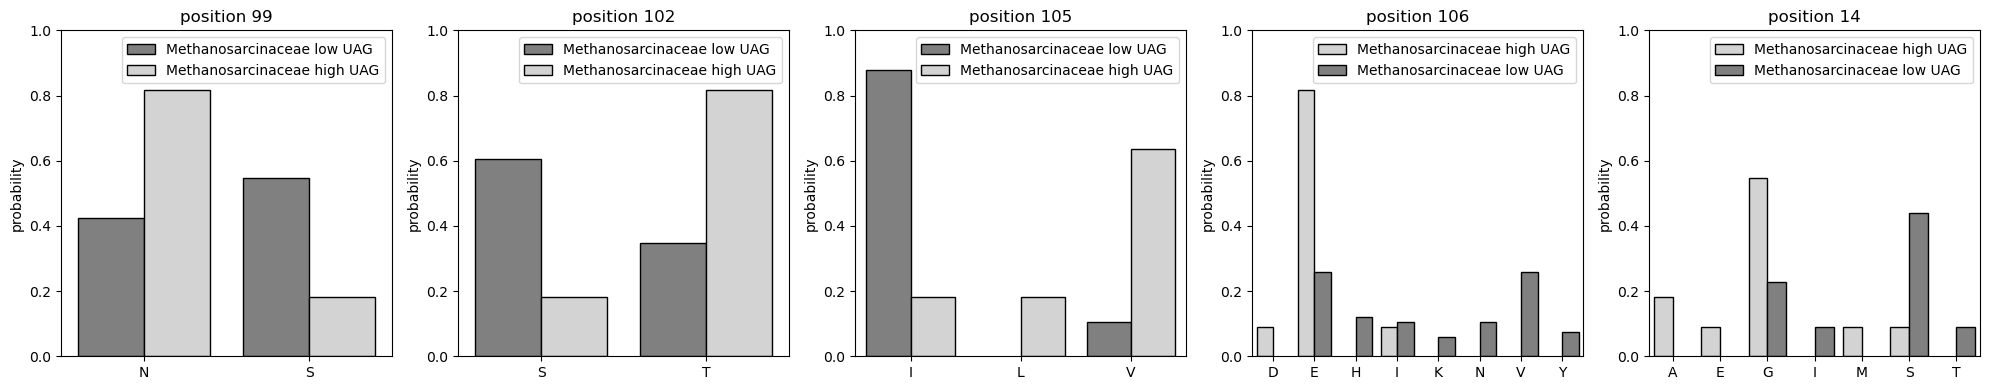

In [124]:
def plot_distribution(figure_df, ax:plt.Axes=None, position:int=None, palette=None, min_frequency:float=0.05):
    figure_df = figure_df[(figure_df.position == position) & (figure_df.frequency > min_frequency)].copy()
    sns.barplot(figure_df, x='residue', y='frequency', hue='category', ax=ax, palette=palette, edgecolor='black')
    # sns.histplot(figure_df[figure_df[position] != '-'], x=position, hue='category', multiple='dodge', stat=stat, ax=ax, palette=palette, common_norm=False, shrink=0.8, edgecolor='black', lw=0.8)
    # shrink_legend_barplot(ax, loc='upper right')
    ax.get_legend().set_title('')
    ax.set_ylabel('probability')
    ax.set_xlabel('')
    ax.set_title(f'position {position}')
    ax.set_ylim(ymin=0, ymax=1)


def figure(taxon:str=None, positions:list=None, min_frequency=0.05, use_dayhoff=False):
    M = {group:get_frequency_matrix(msa_df.loc[arf1_df.index][mask].copy(), use_dayhoff=use_dayhoff, normalize=False) for group, mask in masks.items()}

    figure_df = [M[taxon].assign(category=f'{taxon} low UAG')]
    figure_df += [M['background'].assign(category=f'high UAG')]
    figure_df += [M[f'{taxon}_background'].assign(category=f'{taxon} high UAG')]
    figure_df = pd.concat(figure_df)
    figure_df = figure_df.melt(var_name='residue', id_vars=['category', 'position'], value_name='frequency')

    figure_df = figure_df[figure_df.category != 'high UAG'].copy()
    palette = {f'{taxon} low UAG':'gray', f'{taxon} high UAG':'lightgray', 'high UAG':'lightgray'}


    if len(positions) == 1:
        fig, ax = plt.subplots(figsize=(3.5, 3.5))
        axes = [ax]
    else:
        fig, axes = plt.subplots(ncols=len(positions), figsize=(4 * len(positions), 4), sharey=False)

    for position, ax in zip(positions, axes):
        plot_distribution(figure_df, ax=ax, position=position, palette=palette, min_frequency=min_frequency)
        if use_dayhoff:
            ax.set_xticks(ax.get_xticks(), labels=[dayhoff_descriptions.get(symbol.get_text(), '-').replace(' ', '\n') for symbol in ax.get_xticklabels()], rotation=0, fontsize=15)
            
    fig.tight_layout()
    plt.show()

# figure(taxon=taxon, positions=[81, 88, 403, 283])
# figure(taxon=taxon, positions=[51, 67, 105, 132, 162])
# figure(taxon=taxon, positions=positions)
figure(taxon=taxon, positions=[99, 102, 105, 106, 14])


In [20]:
m_acetivorans_genome_id = 'GCF_000007345.1'
m_acetivorans_id = arf1_df[arf1_df.genome_id == m_acetivorans_genome_id].index[0]
m_acetivorans_alignment = msa_df.loc[m_acetivorans_id].to_dict()
for position in positions:
    print(f'M. acetivorans residue at position {position}:', m_acetivorans_alignment[position])

M. acetivorans residue at position 4: E
M. acetivorans residue at position 105: I
M. acetivorans residue at position 132: K
M. acetivorans residue at position 162: N
M. acetivorans residue at position 244: T
M. acetivorans residue at position 277: D
M. acetivorans residue at position 280: K
M. acetivorans residue at position 306: V
M. acetivorans residue at position 323: S


In [21]:
taxon_ids = arf1_df[arf1_df[level] == taxon].index.values
taxon_genome_ids = arf1_df.loc[taxon_ids].genome_id.values

pwa_df = pd.read_csv('../data/arf1_cleaned_with_methanosarcinaceae_align.tsv', usecols=[0, 1, 2, 3, 4], sep='\t', names=['query_id', 'target_id', 'e_value', 'percent_identity', 'bit_score'])
pwa_df = pwa_df[pwa_df.query_id != pwa_df.target_id].copy() # Remove self-alignments. 
pwa_df = pwa_df[pwa_df.query_id.isin(taxon_ids)]

print(f'Num. alignment pairs for {taxon} (n={len(taxon_ids)}):', len(pwa_df))

Num. alignment pairs for Methanosarcinaceae (n=128): 38272


In [22]:
def print_distance_info(level, taxon):
    taxon_ids = arf1_df[arf1_df[level] == taxon].index.values
    taxon_genome_ids = arf1_df.loc[taxon_ids].genome_id.values

    tree = gtdb_load_ar53_tree(genome_ids=taxon_genome_ids)
    distance_df = tree_get_distances(tree, query_ids=taxon_genome_ids)
    print(f'Max. distance between any two members of {level} {taxon}:', distance_df.distance.max())
    print(f'Min. distance between any two members of {level} {taxon}:', distance_df.distance.min())
    print(f'Mean. distance between any two members of {level} {taxon}:', distance_df.distance.mean())
    print()

print_distance_info('family', taxon)

tree_get_distances: Computing distances between 8128 pairs of leaves.


tree_get_distances: Precomputing distances to leaves.: 100%|██████████| 128/128 [00:00<00:00, 9532.68it/s]
tree_get_distances: 100%|██████████| 8128/8128 [00:00<00:00, 8301.28it/s] 

Max. distance between any two members of family Methanosarcinaceae: 1.0827200000000001
Min. distance between any two members of family Methanosarcinaceae: 0.011669999999999958
Mean. distance between any two members of family Methanosarcinaceae: 0.6115414185531496



In [94]:
if not os.path.exists('./data/methanosarcinaceae_figure-4.csv'):
    figure_df = pwa_df.copy()

    for field in ['genome_id', 'category', 'order', 'family', 'seq', 'genus', 'species', 'tag_percent']:
        figure_df[f'query_{field}'] = figure_df.query_id.map(arf1_df[field].to_dict())
        figure_df[f'target_{field}'] = figure_df.target_id.map(arf1_df[field].to_dict())

    tree = gtdb_load_ar53_tree(genome_ids=set(figure_df.query_genome_id.tolist() + figure_df.target_genome_id.tolist()))
    assert figure_df.query_genome_id.isnull().sum() == 0, f'There are {figure_df.query_genome_id.isnull().sum()} empty genome IDs.'
    assert figure_df.target_genome_id.isnull().sum() == 0, f'There are {figure_df.target_genome_id.isnull().sum()} empty genome IDs.'
    distance_df = tree_get_distances(tree, query_ids=figure_df.query_genome_id.values, target_ids=figure_df.target_genome_id.values)
    figure_df['distance'] = distance_df.distance.values 
    figure_df['query_length'] = figure_df.query_seq.apply(len)
    figure_df['target_length'] = figure_df.target_seq.apply(len)
    figure_df.to_csv('./data/methanosarcinaceae_figure-4.csv')

figure_df = pd.read_csv('./data/methanosarcinaceae_figure-4.csv', index_col=0)
figure_df = figure_df[(figure_df.target_length > 370) & (figure_df.query_length > 370)].copy() # Remove the ones that are N-terminally truncated. 
figure_df = figure_df[(figure_df.query_id != 'JBFHIK010000119.1_5') & (figure_df.target_id != 'JBFHIK010000119.1_5')].copy() # Weird outlier, might be a false positive aRF1. 

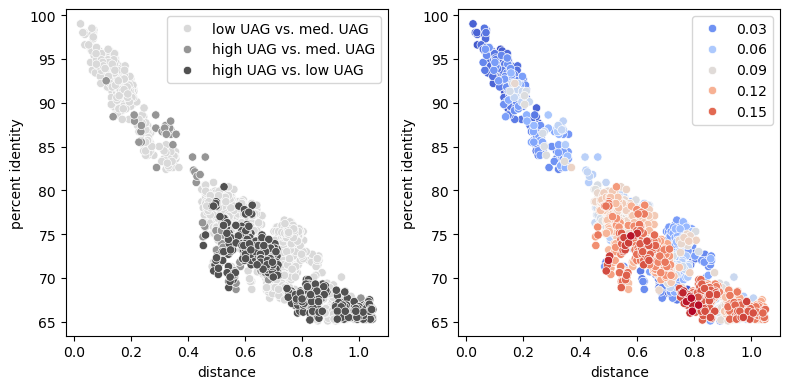

In [99]:


figure_df = figure_df[figure_df.target_length > 400].copy() # Discard those which are N-terminally truncated. 
figure_df['pair'] = [' vs. '.join(sorted([row.target_id, row.query_id])) for row in figure_df.itertuples()]
figure_df = figure_df.drop_duplicates('pair').copy()
figure_df['category'] = [' vs. '.join(sorted([row.target_category, row.query_category])) for row in figure_df.itertuples()]
figure_df = figure_df[figure_df.distance < 1.04992].copy()
figure_df = figure_df[(figure_df.target_genome_id != 'GCA_003164755.1') & (figure_df.query_genome_id != 'GCA_003164755.1')].copy()
figure_df['tag_percent_diff'] = np.abs(figure_df.target_tag_percent - figure_df.query_tag_percent)

fig, (ax_a, ax_b) = plt.subplots(ncols=2, figsize=(8, 4), sharey=False)

mask = (figure_df.percent_identity > 65) & (figure_df.query_category != figure_df.target_category)
sns.scatterplot(figure_df[mask].sort_values('category', ascending=False), x='distance', y='percent_identity', hue='category', palette='Grays', ax=ax_a)
sns.scatterplot(figure_df[mask].sort_values('tag_percent_diff'), x='distance', y='percent_identity', hue='tag_percent_diff', palette='coolwarm', ax=ax_b)

for ax in [ax_a, ax_b]:
    ax.set_ylabel('percent identity')
    ax.get_legend().set_title('')

fig.tight_layout()
plt.show()

# Negative TAG percent diff indicates that the target sequence has a lower TAG than the query, whereas positive indicates the query has a lower TAG than the target. 

In [128]:
def filter_positions(figure_df:pd.DataFrame, max_mismatch_frequency=2, min_mismatch_frequency=0.8, min_position=None, max_position=None, category:str='pyl- vs. pyl-', category_counts=None):
    positions = figure_df[figure_df.category == category].position.value_counts()
    positions = positions / category_counts[category]
    # positions = [x for x in range(min_position, max_position) if (x not in positions[positions.values > max_mismatch_frequency].index)]
    positions = [x for x in range(min_position, max_position) if (x not in positions[positions.values < min_mismatch_frequency].index)]
    # figure_df = figure_df[figure_df.position.isin(positions) & (figure_df.category != category)].copy()
    return figure_df

def get_mismatch_positions(df, msa_df=None, use_dayhoff:bool=True):
    msa_df = msa_df.copy().replace(dayhoff) if use_dayhoff else msa_df
    figure_df = list()
    for row in df.itertuples():
        mismatch_positions = np.where(msa_df.loc[row.query_id].values != msa_df.loc[row.target_id].values)[0]
        for position in mismatch_positions:
            figure_df.append({'category':row.category, 'position':position})
    return pd.DataFrame(figure_df)

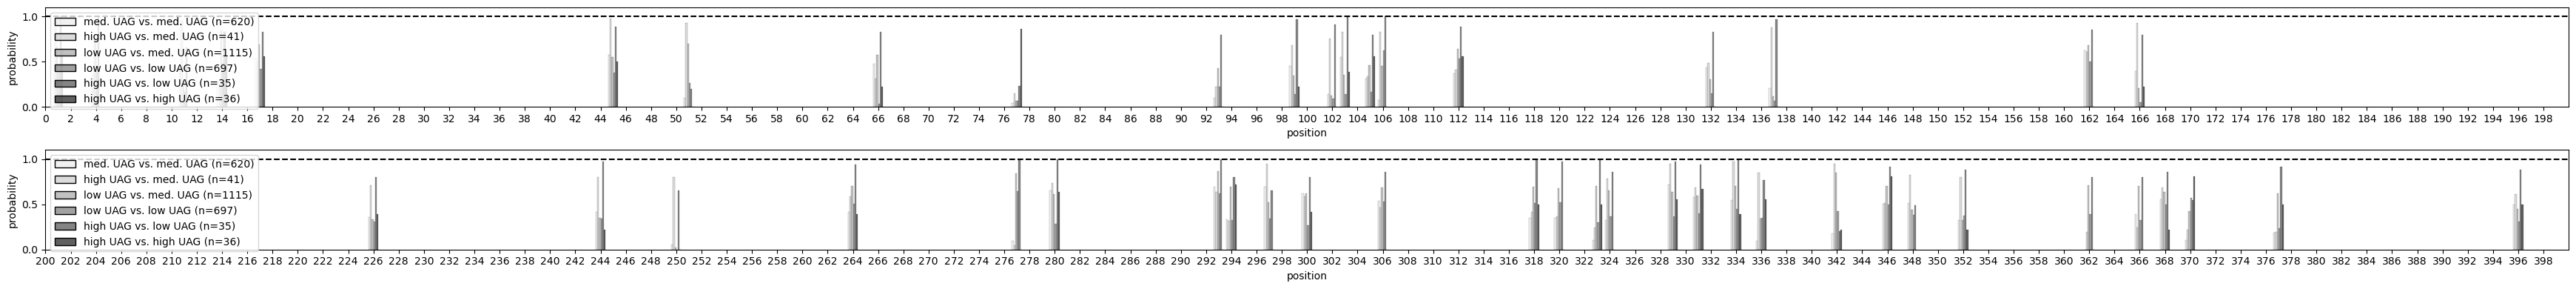

In [129]:

def figure(df, msa_df=msa_df, min_position:int=0, max_position:int=100, use_dayhoff:bool=True, ax:plt.Axes=None, threshold=0.8):

    category_counts = df.groupby('category').size().to_dict()
    figure_df = get_mismatch_positions(df, msa_df=msa_df, use_dayhoff=use_dayhoff)
    # figure_df = filter_positions(figure_df, max_position=max_position, min_position=min_position, category_counts=category_counts, category='high UAG vs. high UAG')
    figure_df = filter_positions(figure_df, max_position=max_position, min_position=min_position, category_counts=category_counts, category='high UAG vs. low UAG')
    # figure_df = figure_df[figure_df.category  != 'med. UAG vs. med. UAG'].copy()

    mask = (figure_df.position < max_position) & (figure_df.position > min_position)
    weights = figure_df[mask]['category'].map(lambda c: 1 / category_counts[c])

    sns.histplot(figure_df[mask], x='position', discrete=True, stat='count', weights=weights, multiple='dodge', shrink=0.8, hue='category', palette='Grays', ax=ax)
    ax.set_ylabel('probability')
    ax.set_xlim(xmin=min_position, xmax=max_position)
    ax.set_xticks(np.arange(min_position, max_position, 2))
    ax.set_ylim(ymin=0, ymax=1.1)
    ax.axhline(1, ls='--', color='black')
    
    categories = figure_df[mask]['category'].unique() # Get unique hue values in the plotted order
    num_bins = len(ax.patches) // len(categories) # Determine how many bins there are per hue
    category_patches = {category: ax.patches[i * num_bins:(i + 1) * num_bins] for i, category in enumerate(categories)}
    for patches in zip(*list(category_patches.values())):
        heights = np.array([patch.get_height() for patch in patches])
        if not np.any(heights > threshold):
            for patch in patches:
                patch.set_visible(False)

    legend = ax.get_legend()
    labels = [label.get_text() for label in legend.get_texts()]
    patches = list(legend.get_patches())
    # labels = [f'{category}' for category in labels]
    labels = [f'{category} (n={category_counts[category]})' for category in labels]
    ax.legend(patches, labels, loc='upper left')


# figure_df_ = figure_df.sort_values('percent_identity', ascending=False).drop_duplicates('category')
# for (min_position, max_position) in [(0, 50), (50, 100), (100, 150), (150, 200), (200, 250), (250, 300), (300, 350), (350, 400)]:
fig, axes = plt.subplots(figsize=(35, 4), nrows=2, sharex=False)
for ax, (min_position, max_position) in zip(axes, [(0, 200), (200, 400)]):
    # figure(figure_df_, min_position=min_position, max_position=max_position, use_dayhoff=True)
    figure(figure_df[figure_df.percent_identity > 75], min_position=min_position, max_position=max_position, use_dayhoff=False, ax=ax)
fig.tight_layout()
plt.show()

# 228, 280, 283, 303, 326, 329, 334, 343

filter_positions: Keeping positions [14, 99, 121, 135, 159, 201, 203, 205, 212, 284, 293, 306, 342, 360]
filter_positions: Keeping positions [14, 99, 121, 135, 159, 201, 203, 205, 212, 284, 293, 306, 342, 360]


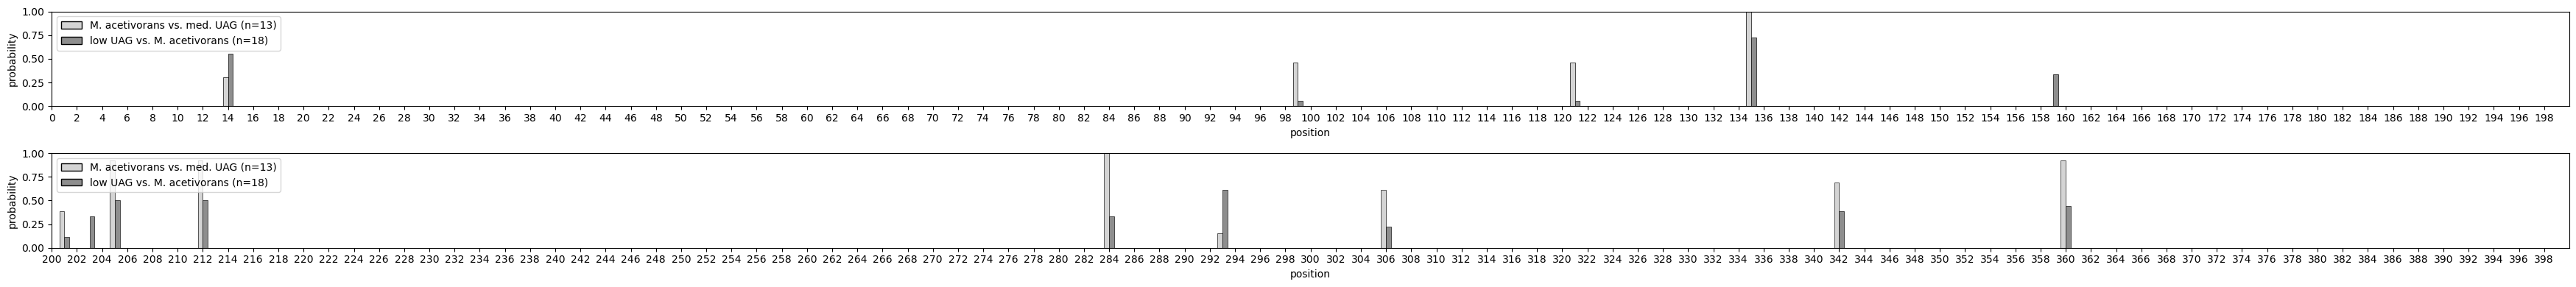

In [132]:
def filter_positions(figure_df, msa_df, categories=None, threshold=0.3, use_dayhoff:bool=False):
    M = {category:get_frequency_matrix(df, normalize=False, use_dayhoff=use_dayhoff) for category, df in msa_df.groupby(categories)}
    scores_df = get_divergence_scores(list(M.values()))
    positions = scores_df[scores_df.score > threshold].position.unique() 
    figure_df = figure_df[figure_df.position.isin(positions)].copy()
    print(f'filter_positions: Keeping positions {positions.tolist()}')
    return figure_df


def figure(df, msa_df=msa_df, arf1_df=arf1_df, min_position:int=0, max_position:int=100, stat:str='probability', use_dayhoff:bool=True, ax:plt.Axes=None):
    df = df[(df.target_id == m_acetivorans_id) | (df.query_id == m_acetivorans_id)].copy()
    df['category'] = [category.replace('med. UAG', 'M. acetivorans', count=1) for category in df.category]
    df = df[~df.category.str.contains('high')].copy()

    msa_df = msa_df.loc[np.unique(df.query_id.tolist() + df.target_id.tolist())].copy()

    category_counts = df.groupby('category').size().to_dict()
    figure_df = get_mismatch_positions(df, msa_df=msa_df, use_dayhoff=use_dayhoff)

    figure_df = filter_positions(figure_df, msa_df, categories=arf1_df.loc[msa_df.index].category, use_dayhoff=use_dayhoff)
    mask = (figure_df.position < max_position) & (figure_df.position > min_position)
    # assert mask.sum() > 0, 'figure: The figure DataFrame is empty.'
    if mask.sum() == 0:
        return 
    
    weights = figure_df[mask]['category'].map(lambda c: 1 / category_counts[c])

    sns.histplot(figure_df[mask], x='position', discrete=True, stat='count', weights=weights, multiple='dodge', shrink=0.8, hue='category', palette='Grays', ax=ax)
    ax.set_ylabel(stat)
    ax.set_xlim(xmin=min_position, xmax=max_position)
    ax.set_xticks(np.arange(min_position, max_position, 2))
    ax.set_ylim(ymin=0, ymax=1)
    legend = ax.get_legend()
    labels = [label.get_text() for label in legend.get_texts()]
    patches = list(legend.get_patches())
    labels = [f'{category} (n={category_counts[category]})' for category in labels]
    ax.legend(patches, labels, loc='upper left')


# figure_df_ = figure_df.sort_values('percent_identity', ascending=False).drop_duplicates('category')
# for (min_position, max_position) in [(0, 50), (50, 100), (100, 150), (150, 200), (200, 250), (250, 300), (300, 350), (350, 400)]:
fig, axes = plt.subplots(figsize=(35, 4), nrows=2, sharex=False)
for ax, (min_position, max_position) in zip(axes, [(0, 200), (200, 400)]):
    # figure(figure_df_, min_position=min_position, max_position=max_position, use_dayhoff=True)
    figure(figure_df[figure_df.percent_identity > 90], min_position=min_position, max_position=max_position, use_dayhoff=False, ax=ax)
fig.tight_layout()
plt.show()
    

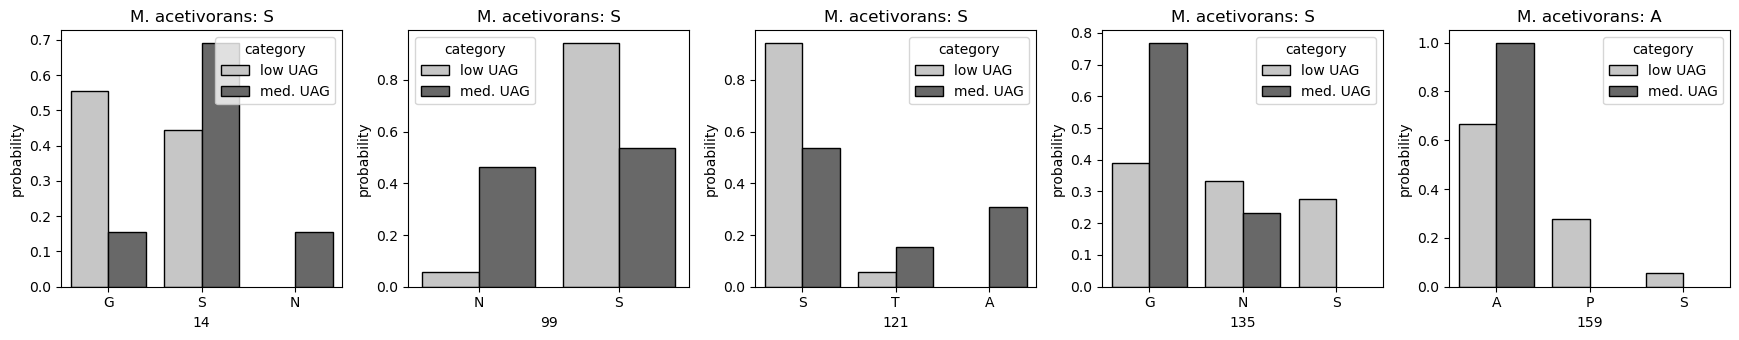

In [133]:
def figure(df, msa_df=msa_df, arf1_df=arf1_df, position:int=None, ax:plt.Axes=None):
    df = df[(df.target_id == m_acetivorans_id) | (df.query_id == m_acetivorans_id)].copy()
    df = df[~df.category.str.contains('high')].copy()

    ids = np.unique(df.query_id.tolist() + df.target_id.tolist()).tolist()
    ids.remove(m_acetivorans_id)
    figure_df = arf1_df.loc[ids].copy()
    figure_df[position] = msa_df[position]
    figure_df = figure_df[figure_df[position] != '-'].copy()
    figure_df = figure_df.groupby(['category', position]).size().reset_index(name='count')
    figure_df['total'] = figure_df.category.map(arf1_df.loc[ids].category.value_counts())
    figure_df['probability'] = figure_df['count'] / figure_df['total']
    
    ax.set_title(f'M. acetivorans: {m_acetivorans_alignment[position]}')
    sns.barplot(figure_df, ax=ax, hue='category', x=position, y='probability', palette='Grays', edgecolor='black')

# Position 106 doesn't look interesting. 
positions = [14, 99, 121, 135, 159]
fig, axes = plt.subplots(figsize=(len(positions) * 3.5, 3.5), ncols=len(positions))
4343
for ax, position in zip(axes, positions):
    figure(figure_df[figure_df.percent_identity > 90], position=position, ax=ax)
fig.tight_layout()
plt.show()

<Axes: xlabel='percent_identity', ylabel='Density'>

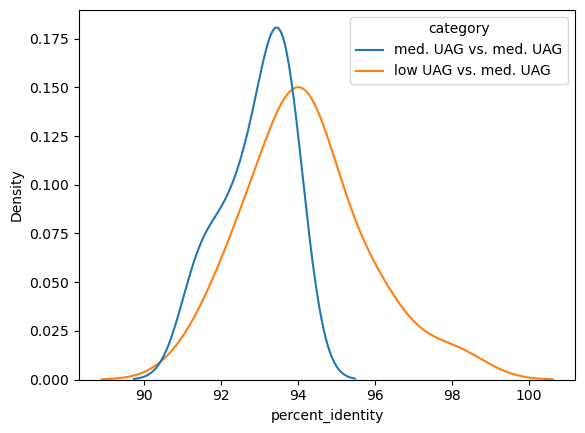

In [78]:
mask = (figure_df.percent_identity > 90)
mask = mask & ((figure_df.target_id == m_acetivorans_id) | (figure_df.query_id == m_acetivorans_id))
mask = mask & (~figure_df.category.str.contains('high'))
sns.kdeplot(figure_df[mask], x='percent_identity', hue='category')

In [ ]:
# # Want to look at the values for these sequences in the Methanosarcina acetivorans. 
# # Unclear why this is not in the dataset, I think perhaps its Pyl machinery did not pass the E-value cutoffs, as it is present in the ncbi/genomes directory. 
# m_acetivorans_genome_id = 'GCF_000007345.1'
# m_acetivorans_seq = load_arf1_dataset()
# m_acetivorans_seq_id = 'NC_003552.1_43'
# m_acetivorans_fasta_df = FASTAFile().from_fasta(f'../data/prodigal/{m_acetivorans_genome_id}.fa').to_df()
# m_acetivorans_seq = m_acetivorans_fasta_df.loc[m_acetivorans_seq_id].seq.item().replace('*', '')

# def get_corresponding_residue(query_seq, target_seq, position:int=0):
#     aligner = Align.PairwiseAligner()
#     aligner.gap_score = -2
#     alignment = aligner.align(query_seq, target_seq)[0]
    
#     pattern = r'([ACDEFGHIKLMNPQRSTVWY\-X]{5,})'
#     alignment_strings = re.findall(pattern, str(alignment), flags=re.MULTILINE)
#     n = len(alignment_strings)
#     aligned_query = ''.join([alignment_strings[i] for i in range(0, n, 2)])
#     aligned_target = ''.join([alignment_strings[i] for i in range(1, n, 2)])

#     print(f'get_corresponding_residue: Alignment length {len(aligned_query)}')
#     print(f'get_corresponding_residue: {aligned_query}')
#     print(f'get_corresponding_residue: {aligned_target}')

#     query_idxs, target_idxs = alignment.inverse_indices
#     query_idxs = {i:idx for i, idx in enumerate(query_idxs)}
#     target_idxs = {idx:i for i, idx in enumerate(target_idxs)}
#     mapped_idx = target_idxs.get(query_idxs[position], None)
#     return target_seq[mapped_idx]

# residue = get_corresponding_residue(seq, m_acetivorans_seq, position=283)
# dayhoff_residue = dayhoff[residue]
# dayhoff_description = dayhoff_descriptions[dayhoff_residue]

# print(residue, dayhoff_residue)
# print(dayhoff_description)


get_corresponding_residue: Alignment length 476
get_corresponding_residue: M---S--KKYEFKRYLEELKNKSGRGTELISLYIPPDKQIHEVVAQLRDEYGQASNIKSKSTRTNVQSAIESILSRLKYISKPPENGLVIFCGAVATGADKTELEVYILEPPEPINIYKYHCDSRFFLEPLEEMLKDKKTYGLIVLDRREATIGILRGKTIEALRYLTSNVPGKHRQGGQSARRFERLREIAIHEFYKRIGDAASEIFLSID---LEGILIGGPSPTKEEFYKGGYLHHELQRKVIGLFDVSYTDDTGLYELVENASEALEQHDLIREKELMRRFMRELAKDGLAV-YGEEEVRRNLIMGSMEVLLISEDLRKIRAKYRCSSCGHSEEVTLS--DRKCPKCGGEMVEETRDIVEELSEIAEQMGTKVEFISTEFEEGEQLLKAFGGIAGILRYRTSH---------------------------------------------------------------------
get_corresponding_residue: MTEQSAHEKYEFKKKLESLRDKKGRSTELISLYIPADKQIFDVTNQLKDEHGQAANIKSKLTRTNVQGAIESLLSRLRYLDKVPENGIVYFTGAVDIGANKTSMESEVIIPPEPITVYKYHCDSSFYLEPLEDMLKDKSTFGLLVLDRREATIGLLVGKRIQAFRNLTSTVPGKQRKGGQSAHRFQQLRLIAIHDFYKRIGDAASEIFMAVDHKDLKGVLIGGPSPTKEEFYGGEFLHHELQKKILGLFDTAYTDESGLSELVNAAGEKLQDLELMGQKNAVRDFFKELIADSGKVAYGETQVRANLEINAVDVLLLSEDLRAERVTTKCSVCGYENKWTRRW---K-P--G-EPAPTAGNCPKCGSSL-EV--TDVIDVVDEFSE---L--ADKSNAKVVFVSTDFDEGSQLMNAFGGIA

In [ ]:
m_acetivorans_seq

'MTEQSAHEKYEFKKKLESLRDKKGRSTELISLYIPADKQIFDVTNQLKDEHGQAANIKSKLTRTNVQGAIESLLSRLRYLDKVPENGIVYFTGAVDIGANKTSMESEVIIPPEPITVYKYHCDSSFYLEPLEDMLKDKSTFGLLVLDRREATIGLLVGKRIQAFRNLTSTVPGKQRKGGQSAHRFQQLRLIAIHDFYKRIGDAASEIFMAVDHKDLKGVLIGGPSPTKEEFYGGEFLHHELQKKILGLFDTAYTDESGLSELVNAAGEKLQDLELMGQKNAVRDFFKELIADSGKVAYGETQVRANLEINAVDVLLLSEDLRAERVTTKCSVCGYENKWTRRWKPGEPAPTAGNCPKCGSSLEVTDVIDVVDEFSELADKSNAKVVFVSTDFDEGSQLMNAFGGIAAILRYSTGV'

In [ ]:
# # Are there any patterns in the residues with high-ish divergence scores?
# fig, ax = plt.subplots(figsize=(3, 3))
# palette = {'Methanomassiliicoccales':'indianred', 'Methanosarcinales':'steelblue'}
# threshold = 0.6
# mask = (figure_df.inter_order_score > threshold) & (figure_df.intra_order_score > threshold)#  & (figure_df.order == 'Methanosarcinales')
# # mask =  (figure_df.intra_order_score > threshold)#  & (figure_df.order == 'Methanosarcinales')

# sns.histplot(figure_df[mask], x='position', bins=10, hue='order', palette=palette, multiple='dodge')
# ax.set_ylabel('count')
# shrink_legend_barplot(ax, loc='upper left')
# plt.show()

In [ ]:
# for order, genome_ids_ in genome_ids.items():
#     arf1_df_ = arf1_df[arf1_df.genome_id.isin(genome_ids_)].copy()
#     msa_df_ = msa_df.loc[arf1_df_.index].copy()

#     tree_write(gtdb_load_ar53_tree(genome_ids=genome_ids_), path=f'../data/trees/ar53_{order}.tree')
#     tree_relabel(f'../data/trees/ar53_{order}.tree', f'../data/trees/ar53_{order}_species.tree', label_map={row.genome_id:row.species for row in arf1_df_.itertuples()})






















In [ ]:
# def get_residue_distribution(df:pd.DataFrame, position, normalize:bool=True, ignore_gaps:bool=False, as_array:bool=True):

#     n = len([col for col in df.columns if (type(col) == int)]) # Length of the alignment. 
#     df = df[['genus'] + list(range(n))].copy() # Make sure not to include excess columns. 
#     df = df[df[position] != '-'].copy() if ignore_gaps else df.copy()
#     aas = list('ACDEFGHIKLMNPQRSTVWY') if ignore_gaps else list('ACDEFGHIKLMNPQRSTVWY-')

#     n_genuses = df.genus.nunique()
#     # Make sure each genus contributes equally to the final distribution by normalizing the initial count. 
#     df = df.groupby('genus')[position].value_counts(normalize=True).reset_index(name='count')
#     df = pd.DataFrame(df.groupby(position).sum())
#     df['frequency'] = df['count'] / n_genuses if normalize else df['count']
#     distribution = df['frequency'].to_dict()
#     distribution.update({aa:0 for aa in aas if (aa not in distribution)})
#     if as_array:
#         distribution = np.array([distribution[aa] for aa in aas])
#     return distribution

# msa_df = msa_df.copy()

# msa_df['category'] = arf1_df.category 
# msa_df['order'] = arf1_df.order
# msa_df['genus'] = arf1_df.genus

In [ ]:
# def get_residue_distribution(df:pd.DataFrame, position, normalize:bool=True, ignore_gaps:bool=True):
#     distribution_df = list()

#     df = df[df[position] != '-'].copy() if ignore_gaps else df.copy()
#     aas = list('ACDEFGHIKLMNPQRSTVWY') if ignore_gaps else list('ACDEFGHIKLMNPQRSTVWY-')

#     for category, df_ in df.groupby('category'):
#         n_genuses = df_.genus.nunique()
#         # Make sure each genus contributes equally to the final distribution by normalizing the initial count. 
#         df_ = df_.groupby('genus')[position].value_counts(normalize=True).reset_index(name='count')
#         df_ = pd.DataFrame(df_.groupby(position).sum())
#         df_['frequency'] = df_['count'] / n_genuses if normalize else df['count']
#         # df_ = df_.set_index(position) # The position column is the amino acid value. 
#         row = df_['frequency'].to_dict()
#         row.update({aa:0 for aa in aas if (aa not in row)})
#         row.update({'category':category})
#         distribution_df.append(row)

#     distribution_df = pd.DataFrame(distribution_df)
#     distribution_df['position'] = position 
#     return distribution_df